# **Visualize the Annual Trend of CVEs Published**

In [1]:
%%capture
# Download and extract data
!mkdir -p jsondata
%cd jsondata
!rm *.json
!rm *.zip
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2010..2023}.json.zip
!unzip -o "*.zip"

In [21]:
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
from plotly.subplots import make_subplots
from matplotlib.dates import date2num

In [3]:
# Extract and process data
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
  with open(filename, 'r', encoding='utf-8') as f:
    nvd_data = json.load(f)
    for entry in nvd_data['CVE_Items']:
      cve = entry['cve']['CVE_data_meta']['ID']
      published_date = entry.get('publishedDate')
      description = entry.get('cve', {}).get('description', {}).get('description_data', [{}])[0].get('value', '')
      new_row = {
          'CVE': cve,
          'Published': published_date,
          'Description': description,
          }
      if not description.startswith('Reject'):
            row_accumulator.append(new_row)

# Create DataFrame
nvd = pd.DataFrame(row_accumulator)

In [4]:
nvd.head()

,CVE,Published,Description
0,CVE-2010-0001,2010-01-29T18:30Z,Integer underflow in the unlzw function in unl...
1,CVE-2010-0002,2010-01-14T18:30Z,The /etc/profile.d/60alias.sh script in the Ma...
2,CVE-2010-0003,2010-01-26T18:30Z,The print_fatal_signal function in kernel/sign...
3,CVE-2010-0004,2010-01-29T18:30Z,ViewVC before 1.1.3 composes the root listing ...
4,CVE-2010-0005,2010-01-29T18:30Z,query.py in the query interface in ViewVC befo...


In [5]:
sum(nvd['Description'].isnull())

0

In [6]:
# Data processing and cleanup
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())

In [7]:
# Convert 'Published' column to datetime
nvd['Published'] = pd.to_datetime(nvd['Published'], errors='coerce')

In [8]:
# Define the date range
start_date = '2010-01-01'
end_date = '2023-12-31'

# Filter the data
nvd = nvd[(nvd['Published'] >= start_date) & (nvd['Published'] <= end_date)]

In [9]:
oldest_date = nvd['Published'].min()
newest_date = nvd['Published'].max()
print(f'Oldest date: {oldest_date}')
print(f'Newest date: {newest_date}')

Oldest date: 2010-01-06 00:00:00
Newest date: 2023-12-31 00:00:00


In [10]:
print(nvd.tail(20))

                  CVE  Published  \
161450  CVE-2013-7472 2019-06-15   
161451  CVE-2013-7473 2019-08-01   
161452  CVE-2013-7474 2019-08-01   
161453  CVE-2013-7475 2019-08-13   
161454  CVE-2013-7476 2019-08-14   
161455  CVE-2013-7477 2019-08-22   
161456  CVE-2013-7478 2019-08-22   
161457  CVE-2013-7479 2019-08-22   
161458  CVE-2013-7480 2019-08-22   
161459  CVE-2013-7481 2019-08-22   
161460  CVE-2013-7482 2019-08-22   
161461  CVE-2013-7483 2019-08-22   
161462  CVE-2013-7484 2019-11-30   
161463  CVE-2013-7485 2020-01-02   
161464  CVE-2013-7486 2020-01-02   
161465  CVE-2013-7487 2020-03-21   
161466  CVE-2013-7488 2020-04-07   
161467  CVE-2013-7489 2020-06-26   
161468  CVE-2013-7490 2020-09-11   
161469  CVE-2013-7491 2020-09-11   

                                              Description  
161450  The "Count per Day" plugin before 3.2.6 for Wo...  
161451  Windu CMS 2.2 allows CSRF via admin/users/?mn=...  
161452  Windu CMS 2.2 allows XSS via the name paramete...  
161

In [11]:
print(len(nvd))

161187


In [12]:
nvd.dtypes

CVE                    object
Published      datetime64[ns]
Description            object
dtype: object

In [13]:
nvd.dtypes

CVE                    object
Published      datetime64[ns]
Description            object
dtype: object

In [14]:
# New Data Frame - Aggregated Counts by Month
yearly_cves = (
    nvd.groupby(nvd['Published'].dt.to_period("Y"))
       .size()
       .reset_index(name='Count')
       .rename(columns={'Published': 'Year'})
)

In [15]:
# Display the resulting DataFrame
print(yearly_cves)

    Year  Count
0   2010   3966
1   2011   4041
2   2012   5246
3   2013   5179
4   2014   7916
5   2015   6485
6   2016   6444
7   2017  14627
8   2018  16501
9   2019  17251
10  2020   4044
11  2021  16525
12  2022  24565
13  2023  28397


In [16]:
# Convert 'Year' to string for plotting
yearly_cves['Year'] = yearly_cves['Year'].astype(str)

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
yearly_cves['Growth Percentage'] = round(yearly_cves['Count'].pct_change() * 100,1)

In [19]:
# Set the growth percentage to 0 if NaN and round to one decimal place
yearly_cves['Growth Percentage'] = yearly_cves['Growth Percentage'].fillna(0)

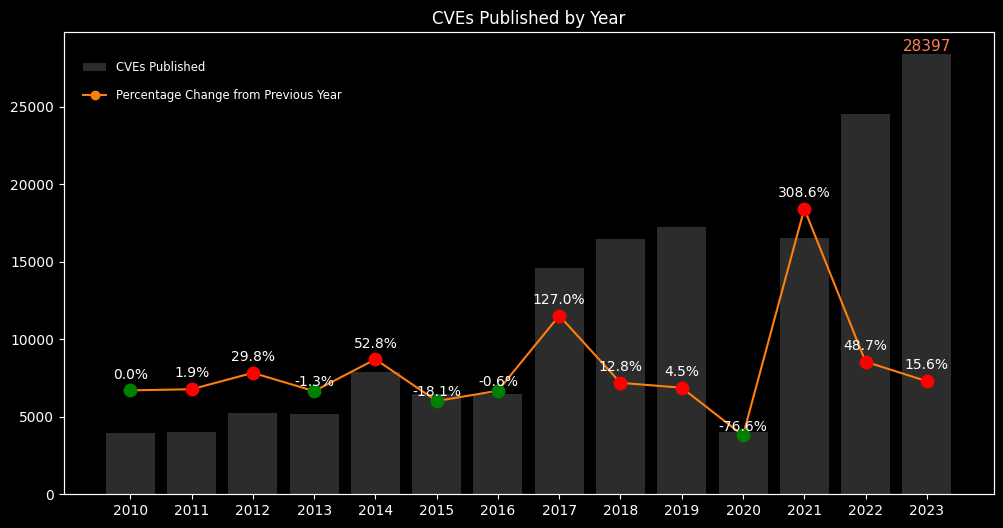

In [20]:
# Use dark background style
plt.style.use('dark_background')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the yearly count as a background
bar_color = 'grey'
ax.bar(yearly_cves['Year'], yearly_cves['Count'], color=bar_color, label='CVEs Published', alpha=0.35)

# Plotting the growth percentage as a line plot on a second y-axis
ax2 = ax.twinx()
line_color = '#ff7f0e'
ax2.plot(yearly_cves['Year'], yearly_cves['Growth Percentage'], color=line_color, marker='o', label='Percentage Change from Previous Year')

# Hide the scale of the secondary axis
ax2.set_yticks([])  # Remove tick marks
ax2.set_ylabel('')   # Remove label

# Highlight the points on the line with the growth percentage
for i, percentage in enumerate(yearly_cves['Growth Percentage']):
    color = 'red' if percentage > 0 else 'green'
    ax2.scatter(yearly_cves['Year'][i], percentage, color=color, s=80, zorder=2, label='')

# Annotate the points on the line with the growth percentage, with increased vertical offset
offset = 15  # Adjust this value as needed
for i, percentage in enumerate(yearly_cves['Growth Percentage']):
    ax2.text(yearly_cves['Year'][i], percentage + offset, f'{percentage:.1f}%',
             ha='center', va='bottom' if percentage >= 0 else 'center', color='white')

# Display the highest 'count' at the top of the corresponding bar
max_count_index = yearly_cves['Count'].idxmax()
ax.text(yearly_cves['Year'][max_count_index], yearly_cves['Count'][max_count_index],
        f'{yearly_cves["Count"].max()}', ha='center', va='bottom', color='coral', fontsize=11)

# Set labels and title
ax.set_xlabel('')
# ax.set_ylabel('Yearly Count', color=bar_color)  # Uncomment if you want the primary y-axis label
plt.title('CVEs Published by Year')

# Adjust y-axis scale for growth percentage
ax2.set_ylim(min(yearly_cves['Growth Percentage']) - 100, max(yearly_cves['Growth Percentage']) + 300)

# Add legends below each other
ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0.01, 0.96), frameon=False)
ax2.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0.01, 0.90), frameon=False)

plt.show()